In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
pd.set_option('max_colwidth', None)
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('./complete_trips_data_2023_d.csv')
df.drop('Unnamed: 0', inplace=True, axis = 1)
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df.drop('date', inplace=True, axis=1)



In [ ]:
df.columns

### Adding a duration in minutes column and reindexing columns

In [3]:
df['duration_minutes'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

In [4]:
df = df.reindex(columns=['ride_id', 'rideable_type', 'started_at', 'ended_at', 'duration_minutes',  'trip_distance', 'start_station_id', 'start_station_name', 'end_station_name', 'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'season', 'AvgTemp', 'member_casual', 'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'start_station_district',
       'end_station_danger_score_.5m', 'end_station_danger_score_1m',
       'end_station_total_docks', 'end_station_district' ])

In [ ]:
df.head()

# **Categorical Analysis**

In [ ]:
sns.set(style='whitegrid')

categorical = ['season', 'rideable_type', 'member_casual']

for each in categorical:
    plt.figure(figsize=(10,6))
    ax = sns.countplot(x=each, data=df, palette='viridis')    
    plt.title(f'Distribution of {each}', fontsize=16)
    plt.xlabel(each.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    ax.tick_params(axis='x', rotation=30)
    ax.tick_params(axis='y', rotation=12)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}',  # Format the count as a comma-separated number
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', 
                    xytext = (0, 10), 
                    textcoords = 'offset points',
                    fontsize=10)
    
    
    
    plt.show()


### **It is evident that most of the rides happen in Summer and Fall, and the riders are members who use Docked bikes as their main bike type.** 

# **Temporal Analysis**

In [5]:
df['start_hour'] = df['started_at'].dt.hour
df['end_hour'] = df['started_at'].dt.hour
df['start_day'] = df['started_at'].dt.dayofweek # Monday=0, Sunday=6
df['start_month'] = df['started_at'].dt.month

### Hourly Usage on Different Days of The Week

In [ ]:
# Convert 'started_at' to day of the week
df['start_day_of_week'] = df['started_at'].dt.day_name()

# Aggregate data
hourly_weekday_counts = df.groupby(['start_hour', 'start_day_of_week'])['ride_id'].count().reset_index(name='count')

# Plot
plt.figure(figsize=(25,20))
sns.lineplot(data=hourly_weekday_counts, x='start_hour', y='count', hue='start_day_of_week', marker='o')
plt.title('Hourly Usage of Bikes by Day of the Week', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Rides', fontsize=14)
plt.xticks(range(0, 24), labels=[f"{i}:00" for i in range(1, 25)])
plt.legend(title='Day of the Week')
sns.despine()
plt.grid(True)
plt.show()


### - It appears that there are distinct peaks in bike usage during the daytime hours across all days of the week, with the 2 highest peaks generally occurring in the morning at 9:00AM and early evening, around 18:00 (6 PM). 
### - There's a noticeable pattern of increased usage on weekdays during typical commuting hours (morning and late afternoon), **which may suggest a significant use of bikes for work commutes.** 
### - **On weekends**, the distribution is more spread out throughout the day with a later peak, which could **indicate more recreational or non-commuting use**. 
### - Additionally, the lowest usage appears to occur in the very early hours of the morning across all days, which is expected as this would be outside of typical commuting or recreational activity hours.

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=df.groupby('start_day').size().index, y=df.groupby('start_day').size().values, palette='muted')
plt.title('Daily Usage of Bikes', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Rides', fontsize=14)
plt.xticks(ticks=range(0, 7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.grid(True)

plt.show()


### It can be seen that the distribution of the number of bike rides over the week is not much varied. It decreases over the weekend as expected. What's surprising is the number of bike rides on `Monday`, these rides should be closely matching the number of rides on the other days of the week (except the weekend) but they are less approxiamtely 20,000 less. 

In [ ]:
# Aggregate data by hour and season
seasonal_hourly_counts = df.groupby(['start_hour', 'season'])['ride_id'].count().reset_index(name='count')

# Plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=seasonal_hourly_counts, x='start_hour', y='count', hue='season', marker='o')
plt.title('Seasonal Hourly Usage of Bikes', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=14)
plt.ylabel('Number of Rides', fontsize=14)
plt.xticks(range(0, 24), labels=[f"{i}:00" for i in range(1, 25)])
plt.legend(title='Season')
sns.despine()
plt.grid(True)
plt.show()


### This plot confirms that indeed the most busy time's of the year are summer and fall, the hourly trends remain the same over all 4 seasons.


### **Most Taken Routes**

In [ ]:
top_routes = df.groupby(['start_station_name', 'end_station_name']).size().reset_index(name='count')

In [ ]:
top_100_routes = top_routes.sort_values('count', ascending=False).head(100)
top_100_routes

In [ ]:
import folium
import branca.colormap as cm

# Initializing a map centered around Boston
boston_map = folium.Map(location=[42.3601, -71.0589], zoom_start=13)

# Generating a color palette
color_palette = cm.linear.YlGnBu_09.scale(0, top_100_routes['count'].max())
top_100_routes['color'] = top_100_routes['count'].apply(color_palette)

# Adding lines to the map for the top 100 routes with labels and tooltips
for idx, row in top_100_routes.iterrows():
    start_station = df[df['start_station_name'] == row['start_station_name']].iloc[0]
    end_station = df[df['end_station_name'] == row['end_station_name']].iloc[0]
    start_coords = [start_station['start_lat'], start_station['start_lng']]
    end_coords = [end_station['end_lat'], end_station['end_lng']]
    
    # Tooltip and popup
    tooltip = f"Route from {start_station['start_station_name']} to {end_station['end_station_name']}"
    popup = folium.Popup(f"{row['count']} rides", parse_html=True)

    # Drawing the lines with colors based on count
    folium.PolyLine(
        locations=[start_coords, end_coords],
        color=row['color'],
        weight=2.5,
        opacity=0.8,
        tooltip=tooltip,
        popup=popup
    ).add_to(boston_map)

# Adding the color legend
color_palette.caption = 'Number of Rides'
boston_map.add_child(color_palette)

# Saving to an HTML file -- Please open this in a browser for an interactive map, you can hover over the routes for info on their respective stations
boston_map.save('top_100_bike_routes_enhanced.html')


In [ ]:
from folium.plugins import HeatMap

# Create a map centered around Boston
map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=13)

# Heatmap for start stations
start_coords = df[['start_lat', 'start_lng']].dropna()
HeatMap(data=start_coords, radius=15).add_to(map_boston)

# Heatmap for end stations
end_coords = df[['end_lat', 'end_lng']].dropna()
HeatMap(data=end_coords, radius=15).add_to(map_boston)

# Display the map
map_boston.save('boston_bike_stations_heatmap.html')


In [ ]:
len(df['start_station_id'].unique()) 

In [ ]:
len(df['end_station_id'].unique())

In [ ]:
# Extracting unique start stations
start_stations = df[['start_station_id', 'start_station_name', 'start_lat', 'start_lng']].drop_duplicates()

# Renaming columns for uniformity
start_stations.columns = ['station_id', 'station_name', 'lat', 'lng']

# Extracting unique end stations
end_stations = df[['end_station_id', 'end_station_name', 'end_lat', 'end_lng']].drop_duplicates()

# Renaming columns for uniformity
end_stations.columns = ['station_id', 'station_name', 'lat', 'lng']

# Combining and removing any duplicates
stations_df = pd.concat([start_stations, end_stations]).drop_duplicates(subset=['station_id'])

In [ ]:
stations_df

In [ ]:
df.head()

In [ ]:
average_dist = df['trip_distance'].mean()

print(f'The average trip distance is {average_dist.round(2)} miles')


In [ ]:
from scipy.spatial import distance_matrix

coordinates = stations_df[['lat', 'lng']]

# Calculate the distance matrix for all stations
dist_matrix = distance_matrix(coordinates, coordinates)

# Replace 0s with np.nan to ignore self-distances
np.fill_diagonal(dist_matrix, np.nan)

# Finding the minimum distance to the nearest station for each station
min_distances = np.nanmin(dist_matrix, axis=1)

# Calculating the average of these minimum distances
average_min_distance = np.nanmean(min_distances)

print(f"The average distance to the nearest station is {average_min_distance:.2} miles.")


In [6]:
# Calculating trip frequency for each station
trip_frequency = df.groupby(['start_station_name'])['ride_id'].count().reset_index(name='trip_frequency')

# Merging the trip frequency back onto the main DataFrame to associate with lat/lng
df = df.merge(trip_frequency, on='start_station_name', how='left')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


# Now create a DataFrame for stations with latitude, longitude, and trip frequency
# We use .drop_duplicates() because there will be multiple entries for each station
stations_with_frequency = df[['start_station_name', 'start_lat', 'start_lng', 'trip_frequency']].drop_duplicates()

# Increasing the figure size
fig = plt.figure(figsize=(14, 10))  # Width, Height in inches
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for latitude, longitude, and trip frequency with larger point size
# and a color map that reflects the trip frequency
sc = ax.scatter(stations_with_frequency['start_lat'], 
                stations_with_frequency['start_lng'], 
                stations_with_frequency['trip_frequency'],
                c=stations_with_frequency['trip_frequency'],  # Color by trip frequency
                cmap='viridis',  # Color map
                s=50)  # Point size

# Adding a color bar
cbar = plt.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Trip Frequency')

# Labels and titles
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Trip Frequency')
plt.title('3D Geo Clustering of Bike Stations')

# Enhancing the plot aesthetics
ax.grid(True)  
plt.tight_layout()  

# Showing the plot
plt.show()



In [ ]:
df.info()

1. **Axes Information**: The x-axis shows the latitude, the y-axis shows the longitude, and the z-axis represents trip frequency. These dimensions suggest that each point in the plot corresponds to a bike station's geographical location and its usage intensity.

2. **Clustering**: Points are clustered according to geographical proximity, with denser clusters likely indicating areas with higher numbers of bike stations or areas with higher usage.

4. **Spatial Distribution**: There is a noticeable concentration of bike stations within a specific latitude and longitude range, which correspond to the **Backbay, Fenway-Kenmore, Boston's downtown, Somerville and the Cambridge area.**

5. **Outliers**: There are a few bike stations positioned away from the main cluster, which are in the suburbs of Boston such as **Everett, Revere, Malden, Hydepark, and Dorchester.**

6. **Trip Frequency**: Most bike stations have a relatively low to moderate trip frequency, with a few stations showing very high usage. These high-frequency stations are located at strategic points, like major public areas, transit hubs, or commercial centers.

7. **Analysis Focus**: For our project, stations with higher trip frequencies (warmer colors) would be of particular interest, as optimizing their placement could have a more significant impact on overall service efficiency.

### **In terms of your project's next steps, we  want to investigate the characteristics of the high-frequency stations to understand why they are popular and determine if additional stations are needed in those areas. Similarly, examining the low-frequency stations could reveal if they are poorly placed or if there are other factors influencing their low usage.**

 >> ### **Filtering Dataset based on trip frequency , Removing the stations with trip frequency <=5000. i.e. The number of trip's that originate from a start station are less than 5000**

In [7]:
df = df[df['trip_frequency'] > 5000]

In [8]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'duration_minutes', 'trip_distance', 'start_station_id',
       'start_station_name', 'end_station_name', 'end_station_id', 'start_lat',
       'start_lng', 'end_lat', 'end_lng', 'season', 'AvgTemp', 'member_casual',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'start_station_district',
       'end_station_danger_score_.5m', 'end_station_danger_score_1m',
       'end_station_total_docks', 'end_station_district', 'start_hour',
       'end_hour', 'start_day', 'start_month', 'trip_frequency'],
      dtype='object')

In [9]:
df

ride_id rideable_type          started_at  \
13       85A52A54DC77E832   docked_bike 2023-04-13 17:55:22   
14       17A0784E0EAE3DE2   docked_bike 2023-04-27 17:26:03   
19       898C9A7B7C01D1CE   docked_bike 2023-04-13 20:09:14   
20       0C3C85353AC1D0A0   docked_bike 2023-04-22 18:43:04   
21       427BDC3864BACB22   docked_bike 2023-04-29 12:52:25   
...                   ...           ...                 ...   
1140754  5715442AE6B59F9F  classic_bike 2023-12-08 07:47:37   
1140755  A0792D35A364FC36  classic_bike 2023-12-10 21:48:12   
1140756  FD56933EA9FEEA63  classic_bike 2023-12-10 11:10:49   
1140758  94A5706C077F4347  classic_bike 2023-12-09 18:01:34   
1140759  78981F659276D29B  classic_bike 2023-12-22 13:33:30   

                   ended_at  duration_minutes  trip_distance start_station_id  \
13      2023-04-13 18:09:57         14.583333       1.877944           M32055   
14      2023-04-27 17:42:33         16.500000       1.329318           M32026   
19      2023-04-13 20:16:01          6.783333       0.328890           M32055   
20      2023-04-22 19:05:06         22.033333       2.772623           M32026   
21      2023-04-29 12:59:52          7.450000       0.761536           M32026   
...                     ...               ...            ...              ...   
1140754 2023-12-08 07:57:03          9.433333       1.188867           A32025   
1140755 2023-12-10 21:54:38          6.433333       0.765234           A32002   
1140756 2023-12-10 11:20:11          9.366667       0.765234           A32002   
1140758 2023-12-09 18:21:52         20.300000       1.829355           A32002   
1140759 2023-12-22 13:42:30          9.000000       0.411032           A32025   

                                start_station_name  \
13         Harvard St at Greene-Rose Heritage Park   
14       359 Broadway - Broadway at Fayette Street   
19         Harvard St at Greene-Rose Heritage Park   
20       359 Broadway - Broadway at Fayette Street   
21       359 Broadway - Broadway at Fayette Street   
...                                            ...   
1140754          Nashua Street at Red Auerbach Way   
1140755            Commonwealth Ave at Agganis Way   
1140756            Commonwealth Ave at Agganis Way   
1140758            Commonwealth Ave at Agganis Way   
1140759          Nashua Street at Red Auerbach Way   

                        end_station_name end_station_id  start_lat  start_lng  \
13                     Lesley University         M32039  42.365994 -71.095222   
14                     Lesley University         M32039  42.370803 -71.104412   
19                 Mass Ave at Albany St         M32061  42.365994 -71.095222   
20           Lewis Wharf at Atlantic Ave         D32006  42.370803 -71.104412   
21                 Mass Ave at Albany St         M32061  42.370803 -71.104412   
...                                  ...            ...        ...        ...   
1140754         Stuart St at Berkeley St         D32049  42.365673 -71.064263   
1140755            Park Dr at Buswell St         A32008  42.351692 -71.119035   
1140756            Park Dr at Buswell St         A32008  42.351692 -71.119035   
1140758  Inman Square at Springfield St.         M32062  42.351692 -71.119035   
1140759            EF - North Point Park         M32034  42.365673 -71.064263   

           end_lat    end_lng  season  AvgTemp member_casual  \
13       42.386748 -71.119019  spring     68.5        member   
14       42.386748 -71.119019  spring     50.5        member   
19       42.361358 -71.096703  spring     68.5        member   
20       42.363871 -71.050877  spring     48.0        member   
21       42.361358 -71.096703  spring     50.0        member   
...            ...        ...     ...      ...           ...   
1140754  42.349544 -71.072421  winter     34.5        member   
1140755  42.347241 -71.105301  winter     53.0        member   
1140756  42.347241 -71.105301  winter     53.0        member   
1140758  42.374267 -71.100

In [ ]:
stations_with_frequency_more_than_5000 = df[['start_station_name', 'start_lat', 'start_lng', 'trip_frequency']].drop_duplicates()

# Increasing the figure size
fig = plt.figure(figsize=(14, 10))  # Width, Height in inches
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for latitude, longitude, and trip frequency with larger point size
# and a color map that reflects the trip frequency
sc = ax.scatter(stations_with_frequency_more_than_5000['start_lat'], 
                stations_with_frequency_more_than_5000['start_lng'], 
                stations_with_frequency_more_than_5000['trip_frequency'],
                c=stations_with_frequency_more_than_5000['trip_frequency'],  # Color by trip frequency
                cmap='viridis',  # Color map
                s=50)  # Point size

# Adding a color bar
cbar = plt.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Trip Frequency')

# Labels and titles
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Trip Frequency')
plt.title('3D Geo Clustering of Bike Stations')

# Enhancing the plot aesthetics
ax.grid(True)  
plt.tight_layout()  

# Showing the plot
plt.show()

### **We can see the data is much better represented now, as the data is spread out and these points can give valuabel information when we apply DBSCAN / HDBSCAN on this data**

**Strategic Placement Considerations: The stations shown in yellow or green, indicating the highest usage, could be critical nodes in the bike-sharing network. These stations might benefit from additional resources, such as more bikes or better infrastructure.**

In [ ]:
# Create a map centered around Boston
map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=13)

# Heatmap for start stations
start_coords = df[['start_lat', 'start_lng']].dropna()
HeatMap(data=start_coords, radius=15).add_to(map_boston)

# Heatmap for end stations
end_coords = df[['end_lat', 'end_lng']].dropna()
HeatMap(data=end_coords, radius=15).add_to(map_boston)

# Display the map
map_boston.save('filtered_boston_bike_stations_heatmap.html')

### >> **Filtering for trip frequency being greater than 10,000 to see if we get a better representatiion of our data ?**

In [ ]:
filtered_df_10k = df[df['trip_frequency'] > 10000]

In [ ]:
stations_with_frequency_more_than_10000 = filtered_df_10k[['start_station_name', 'start_lat', 'start_lng', 'trip_frequency']].drop_duplicates()

# Increasing the figure size
fig = plt.figure(figsize=(14, 10))  # Width, Height in inches
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for latitude, longitude, and trip frequency with larger point size
# and a color map that reflects the trip frequency
sc = ax.scatter(stations_with_frequency_more_than_10000['start_lat'], 
                stations_with_frequency_more_than_10000['start_lng'], 
                stations_with_frequency_more_than_10000['trip_frequency'],
                c=stations_with_frequency_more_than_10000['trip_frequency'],  # Color by trip frequency
                cmap='viridis',  # Color map
                s=50)  # Point size

# Adding a color bar
cbar = plt.colorbar(sc, shrink=0.5, aspect=5)
cbar.set_label('Trip Frequency')

# Labels and titles
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Trip Frequency')
plt.title('3D Geo Clustering of Bike Stations')

# Enhancing the plot aesthetics
ax.grid(True)  
plt.tight_layout()  

# Showing the plot
plt.show()

In [ ]:
# Create a map centered around Boston
map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=13)

# Heatmap for start stations
start_coords = filtered_df_10k[['start_lat', 'start_lng']].dropna()
HeatMap(data=start_coords, radius=15).add_to(map_boston)

# Heatmap for end stations
end_coords = filtered_df_10k[['end_lat', 'end_lng']].dropna()
HeatMap(data=end_coords, radius=15).add_to(map_boston)

# Display the map
map_boston.save('filtered_10k_boston_bike_stations_heatmap.html')

### >> **We can see that a lot of data is lost when we filter for trip frequency > 10000, so we stick to the trip frequency being greater than 5000 for our clustering**

In [10]:
df

ride_id rideable_type          started_at  \
13       85A52A54DC77E832   docked_bike 2023-04-13 17:55:22   
14       17A0784E0EAE3DE2   docked_bike 2023-04-27 17:26:03   
19       898C9A7B7C01D1CE   docked_bike 2023-04-13 20:09:14   
20       0C3C85353AC1D0A0   docked_bike 2023-04-22 18:43:04   
21       427BDC3864BACB22   docked_bike 2023-04-29 12:52:25   
...                   ...           ...                 ...   
1140754  5715442AE6B59F9F  classic_bike 2023-12-08 07:47:37   
1140755  A0792D35A364FC36  classic_bike 2023-12-10 21:48:12   
1140756  FD56933EA9FEEA63  classic_bike 2023-12-10 11:10:49   
1140758  94A5706C077F4347  classic_bike 2023-12-09 18:01:34   
1140759  78981F659276D29B  classic_bike 2023-12-22 13:33:30   

                   ended_at  duration_minutes  trip_distance start_station_id  \
13      2023-04-13 18:09:57         14.583333       1.877944           M32055   
14      2023-04-27 17:42:33         16.500000       1.329318           M32026   
19      2023-04-13 20:16:01          6.783333       0.328890           M32055   
20      2023-04-22 19:05:06         22.033333       2.772623           M32026   
21      2023-04-29 12:59:52          7.450000       0.761536           M32026   
...                     ...               ...            ...              ...   
1140754 2023-12-08 07:57:03          9.433333       1.188867           A32025   
1140755 2023-12-10 21:54:38          6.433333       0.765234           A32002   
1140756 2023-12-10 11:20:11          9.366667       0.765234           A32002   
1140758 2023-12-09 18:21:52         20.300000       1.829355           A32002   
1140759 2023-12-22 13:42:30          9.000000       0.411032           A32025   

                                start_station_name  \
13         Harvard St at Greene-Rose Heritage Park   
14       359 Broadway - Broadway at Fayette Street   
19         Harvard St at Greene-Rose Heritage Park   
20       359 Broadway - Broadway at Fayette Street   
21       359 Broadway - Broadway at Fayette Street   
...                                            ...   
1140754          Nashua Street at Red Auerbach Way   
1140755            Commonwealth Ave at Agganis Way   
1140756            Commonwealth Ave at Agganis Way   
1140758            Commonwealth Ave at Agganis Way   
1140759          Nashua Street at Red Auerbach Way   

                        end_station_name end_station_id  start_lat  start_lng  \
13                     Lesley University         M32039  42.365994 -71.095222   
14                     Lesley University         M32039  42.370803 -71.104412   
19                 Mass Ave at Albany St         M32061  42.365994 -71.095222   
20           Lewis Wharf at Atlantic Ave         D32006  42.370803 -71.104412   
21                 Mass Ave at Albany St         M32061  42.370803 -71.104412   
...                                  ...            ...        ...        ...   
1140754         Stuart St at Berkeley St         D32049  42.365673 -71.064263   
1140755            Park Dr at Buswell St         A32008  42.351692 -71.119035   
1140756            Park Dr at Buswell St         A32008  42.351692 -71.119035   
1140758  Inman Square at Springfield St.         M32062  42.351692 -71.119035   
1140759            EF - North Point Park         M32034  42.365673 -71.064263   

           end_lat    end_lng  season  AvgTemp member_casual  \
13       42.386748 -71.119019  spring     68.5        member   
14       42.386748 -71.119019  spring     50.5        member   
19       42.361358 -71.096703  spring     68.5        member   
20       42.363871 -71.050877  spring     48.0        member   
21       42.361358 -71.096703  spring     50.0        member   
...            ...        ...     ...      ...           ...   
1140754  42.349544 -71.072421  winter     34.5        member   
1140755  42.347241 -71.105301  winter     53.0        member   
1140756  42.347241 -71.105301  winter     53.0        member   
1140758  42.374267 -71.100

# **Data Prep For Clustering**

### **Given our project's objective to optimize bike station placement and improve service efficiency, our clustering should aim to capture patterns related to `bike usage` `frequency`, `demographics`, and `environmental factors` that could influence bike-sharing behaviors.**

For our `clustering_df`, The following features will affect the clustering process:

1. **Geographical Features**:
   - `start_lat`: Latitude of the start station.
   - `start_lng`: Longitude of the start station.
   These are crucial for identifying spatial patterns and clustering stations based on location.

2. **Temporal Features**:
   - `start_hour`: Hour of the day when the trip started.
   - `start_day`: Day of the month.
   - `start_month`: Month of the year.
   - `start_day_of_week`: Day of the week.
   Temporal features can help identify usage patterns related to time.

3. **Weather Features**:
   - `AvgTemp`: Average temperature might influence the willingness to use a bike.

4. **Trip Features**:
   - `duration_minutes`: Duration of the trip.
   - `trip_distance`: Distance of the trip.
   These features can help understand the nature of the trips.

5. **Usage Frequency**:
   - `trip_frequency`: The frequency of trips started or ended at the station.
   This is your target feature for optimization, indicating the popularity or demand of the station.

6. **Categorical Features**:
   - `season`: Season of the year may affect usage.
   - `member_casual`: Type of user could indicate different usage patterns.
   - `rideable_type`: Type of bike might influence the preference or usage.

For the categorical features, we will need to convert them into a numerical format suitable for clustering. This can be done using one-hot encoding or label encoding. 

In [11]:
clustering_df = df[['start_lat', 'start_lng', 'end_lat', 'end_lng', 'duration_minutes', 'trip_distance', 'trip_frequency', 'season', 'AvgTemp', 'start_month', 'start_day', 'start_hour', 'member_casual', 'rideable_type', 'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'start_station_district',
       'end_station_danger_score_.5m', 'end_station_danger_score_1m',
       'end_station_total_docks', 'end_station_district']]

# 'end_lat','end_lng' 'ride_id'

### **>> Note: Temporal ranges start from 0 i.e. for the 7 days of the week the mapping is 0-6, similarly 0-23 for hours**

### **Categorical Conversion** 
### - Using Ordinal Mapping for `season` as they inherit a natural order,  while `member_casual` and `rideable_type` will be encoded using One-Hot encoding

In [12]:
seasonal_order = {
    'spring' : 1,
    'summer' : 2,
    'fall' : 3,
    'winter' : 4
}

clustering_df['season_ordinal'] = clustering_df['season'].map(seasonal_order)
clustering_df.drop('season', inplace = True, axis = 1)

/var/folders/jb/rytm79zx10zcs2wb4zr2ptxr0000gn/T/ipykernel_58826/3195653514.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df['season_ordinal'] = clustering_df['season'].map(seasonal_order)
/var/folders/jb/rytm79zx10zcs2wb4zr2ptxr0000gn/T/ipykernel_58826/3195653514.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering_df.drop('season', inplace = True, axis = 1)


In [ ]:
for i in ["member_casual", 'rideable_type']:
    print(df[i].value_counts(), '\n')

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=clustering_df.groupby('start_month').size().index, y=df.groupby('start_month').size().values, marker='o', linestyle='-', color='blue')
plt.title('Monthly Usage of Bikes', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Rides', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()


In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Defining the transformer with OneHotEncoder for categorical features
categorical_features = ['member_casual', 'rideable_type', 'start_station_district', 'end_station_district']
one_hot_encoder = OneHotEncoder()

# Creating a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', one_hot_encoder, categorical_features)
    ],
    remainder='passthrough'  # This will keep all other columns untouched
)

# Fitting and transform the DataFrame
clustering_df_encoded = preprocessor.fit_transform(clustering_df)

# To get feature names after one hot encoding (useful for making sense of the output)
feature_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Convertting the output back to a DataFrame, if needed
clustering_df_encoded = pd.DataFrame(clustering_df_encoded, columns=feature_names + list(clustering_df.drop(categorical_features, axis=1).columns))


In [14]:
clustering_df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631494 entries, 0 to 631493
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   member_casual_casual               631494 non-null  float64
 1   member_casual_member               631494 non-null  float64
 2   rideable_type_classic_bike         631494 non-null  float64
 3   rideable_type_docked_bike          631494 non-null  float64
 4   rideable_type_electric_bike        631494 non-null  float64
 5   start_station_district_Boston      631494 non-null  float64
 6   start_station_district_Cambridge   631494 non-null  float64
 7   start_station_district_Somerville  631494 non-null  float64
 8   end_station_district_Arlington     631494 non-null  float64
 9   end_station_district_Boston        631494 non-null  float64
 10  end_station_district_Brookline     631494 non-null  float64
 11  end_station_district_Cambridge     6314

### **Normalizing the Data**

### Specifying datatypes after one hot encoding

In [ ]:
clustering_df_encoded.columns

In [16]:
# Converting specific columns to float or int as appropriate
float_cols = ['start_lat', 'start_lng', 'duration_minutes', 'trip_distance', 'AvgTemp']
int_cols = ['trip_frequency', 'start_month', 'start_day', 'start_hour', 'season_ordinal', 'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks']

# Using .astype() to convert column types
clustering_df_encoded[float_cols] = clustering_df_encoded[float_cols].astype(float)
clustering_df_encoded[int_cols] = clustering_df_encoded[int_cols].astype(int)

# For the one-hot encoded columns, they should also be integers (0 or 1)
one_hot_cols = ['member_casual_casual', 'member_casual_member', 'rideable_type_classic_bike', 
                'rideable_type_docked_bike', 'rideable_type_electric_bike',  'start_station_district_Boston',
       'start_station_district_Cambridge', 'start_station_district_Somerville',
       'end_station_district_Arlington', 'end_station_district_Boston',
       'end_station_district_Brookline', 'end_station_district_Cambridge',
       'end_station_district_Chelsea', 'end_station_district_Everett',
       'end_station_district_Malden', 'end_station_district_Medford',
       'end_station_district_Newton', 'end_station_district_Revere',
       'end_station_district_Salem', 'end_station_district_Somerville',
       'end_station_district_Watertown']


clustering_df_encoded[one_hot_cols] = clustering_df_encoded[one_hot_cols].astype(int)

# Checking the dtypes again
clustering_df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631494 entries, 0 to 631493
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   member_casual_casual               631494 non-null  int64  
 1   member_casual_member               631494 non-null  int64  
 2   rideable_type_classic_bike         631494 non-null  int64  
 3   rideable_type_docked_bike          631494 non-null  int64  
 4   rideable_type_electric_bike        631494 non-null  int64  
 5   start_station_district_Boston      631494 non-null  int64  
 6   start_station_district_Cambridge   631494 non-null  int64  
 7   start_station_district_Somerville  631494 non-null  int64  
 8   end_station_district_Arlington     631494 non-null  int64  
 9   end_station_district_Boston        631494 non-null  int64  
 10  end_station_district_Brookline     631494 non-null  int64  
 11  end_station_district_Cambridge     6314

### **Given that your geographic coordinates are concentrated within a relatively small area — a 12-mile radius around Boston with some surrounding suburbs—the distortion caused by treating latitude and longitude as Euclidean coordinates should be minimal. This is because, over short distances, the Earth's surface can be reasonably approximated as flat, and therefore, the Euclidean distance can be a good proxy for actual geographic distance.**

### **Considering the following heatmap, which shows a concentration of activity within a specific urban area, and ourchoice of HDBSCAN, which is a density-based clustering method that can handle varied densities and is less sensitive to the "curse of dimensionality," we have some flexibility in your approach to normalization:**
Given that your geographic coordinates are concentrated within a relatively small area—a 12-mile radius around Boston with some surrounding suburbs—the distortion caused by treating latitude and longitude as Euclidean coordinates should be minimal. This is because, over short distances, the Earth's surface can be reasonably approximated as flat, and therefore, the Euclidean distance can be a good proxy for actual geographic distance.

Considering the heatmap you provided, which shows a concentration of activity within a specific urban area, and your choice of HDBSCAN, which is a density-based clustering method that can handle varied densities and is less sensitive to the "curse of dimensionality," you have some flexibility in your approach to normalization:

### Normalization Approach for Geo Coordinates + Other Data

1. **HDBSCAN without Normalization of Geo Coordinates**:
   - We can apply HDBSCAN directly to the geographic coordinates without normalization, as HDBSCAN is adept at handling different scales and does not necessarily require all features to be on the same scale.
   - We would normalize the non-geographic features separately if they are on vastly different scales or have very different variances.

2. **Minimal Distortion Normalization**:
   - Since the area is relatively small and we are looking at urbam analytics, a simple Min-Max scaling to normalize your features could suffice. It will preserve the relative distances between points.
   - Using Min-Max scaling on latitude and longitude to ensure we have a similar scale to our other features, such as temperature, trip frequency, etc.



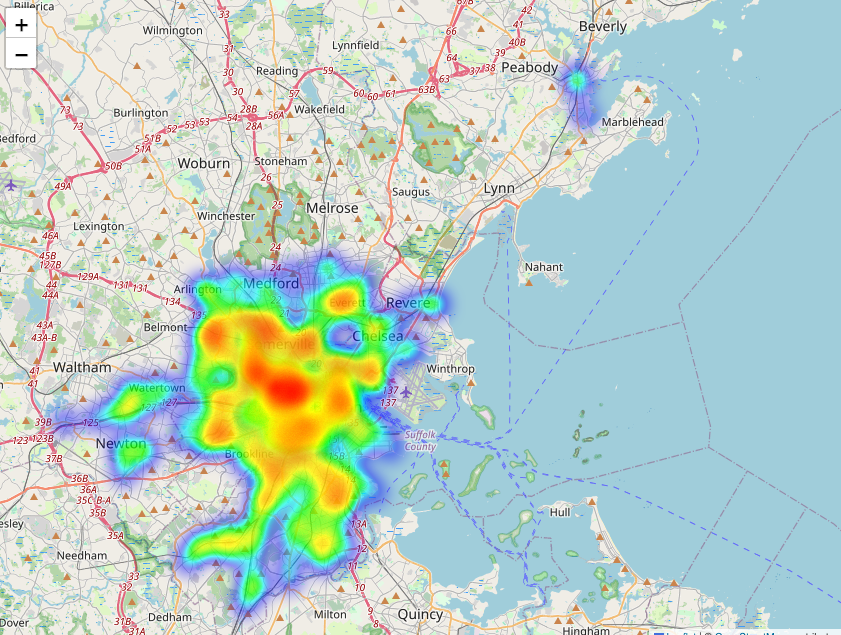

In [ ]:
# features_to_visualize = ['duration_minutes', 'trip_distance', 'AvgTemp', 'trip_frequency', 
#                          'start_month', 'start_day', 'start_hour', 'season_ordinal']

# # Plot histograms for each feature to visualize distributions
# for feature in features_to_visualize:
#     plt.figure(figsize=(10, 4))
#     sns.histplot(clustering_df_encoded[feature], kde=True)
#     plt.title(f'Distribution of {feature}')
#     plt.xlabel(feature)
#     plt.ylabel('Frequency')
#     plt.show()

# # Plot boxplots for each feature to visualize outliers
# for feature in features_to_visualize:
#     plt.figure(figsize=(10, 4))
#     sns.boxplot(x=clustering_df_encoded[feature])
#     plt.title(f'Boxplot of {feature}')
#     plt.xlabel(feature)
#     plt.show()


clustering_df_encoded.info()

### **1. HDBSCAN without Normalization of Geo Coordinates**:


In [18]:
from sklearn.preprocessing import StandardScaler
import hdbscan


### **Since HDBSCAN does not require the features to be in a specific range but rather benefits from the features being on a similar scale, we will be using Standard Scaling for our numerical features except for the latitude and longitude coordinates. We will keep the original latitudes and longitudes for later use and create normalized versions of other variables for clustering purposes.**

In [19]:
# Columns to normalize - excluding lat/long for now based on your preference
columns_to_normalize = ['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp', 
                        'start_month', 'start_day', 'start_hour', 
                        'start_station_danger_score_.5m', 'start_station_danger_score_1m', 
                        'start_station_total_docks', 'end_station_danger_score_.5m', 
                        'end_station_danger_score_1m', 'end_station_total_docks', 'season_ordinal']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
clustering_df_encoded[columns_to_normalize] = scaler.fit_transform(clustering_df_encoded[columns_to_normalize])

# Choosing the number for the parameter `min_cluster_size` for the HDBSCAN Algorithm

In [ ]:
# Histogram of trip frequencies
plt.figure(figsize=(10, 6))
sns.histplot(clustering_df['trip_frequency'], bins=50, kde=False)
plt.title('Histogram of Trip Frequencies')
plt.xlabel('Trip Frequency')
plt.ylabel('Number of Data Points')
plt.show()

# Histogram of trip distances
plt.figure(figsize=(10, 6))
sns.histplot(clustering_df['trip_distance'], bins=50, kde=False)
plt.title('Histogram of Trip Distances')
plt.xlabel('Trip Distance')
plt.ylabel('Number of Data Points')
plt.show()


### Suggested Parameter for HDBS
Considering the trip frequency histogram, we might start with a `min_cluster_size` of around 500 to exclude the noise from very small clusters and focus on more significant patterns. We can then adjust this parameter upwards if we find too many small clusters or downwards if we are missing meaningful clusters.




In [ ]:
# clustering_df_encoded.drop('clusters', inplace=True, axis=1)

In [ ]:
# Initializing the model
clusterer = hdbscan.HDBSCAN(min_cluster_size=500, 
                            min_samples=None,  # Default: same as min_cluster_size
                            gen_min_span_tree=True,
                            metric='euclidean',  # Using 'haversine' distance for geo-coordinates
                            cluster_selection_epsilon=0.0,  # Adjust based on your needs
                            allow_single_cluster=False)  # Adjust based on your analysis goals

# Fitting the model
clusterer.fit(clustering_df_encoded)

In [ ]:
# Adding the cluster labels to the DataFrame
clustering_df_encoded['clusters'] = clusterer.labels_
cluster_sizes = clustering_df_encoded['clusters'].value_counts()

In [ ]:
cluster_sizes

### **This indensed tree plot indicates one dominant cluster (the tall yellow line), a few smaller clusters (lines with shorter horizontal merges), and several points that could be considered noise or outliers (points that merge at the very top of the plot).**

In [ ]:
# Plotting the condensed tree
plt.figure(figsize=(25,25))

clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D visualization
sc = ax.scatter(
    clustering_df_encoded['start_lng'],
    clustering_df_encoded['start_lat'],
    clustering_df_encoded['clusters'],  # Replace with your third dimension
    c=clustering_df_encoded['clusters'],
    cmap='viridis',
    s=1
)

# Setting labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Clusters')  # Replace with your third dimension label

# Title and colorbar
plt.title('3D Clusters by HDBSCAN')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Cluster Label')

plt.show()


In [ ]:
# Create a map centered at an approximate location for Boston
map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

# Define colors for the clusters, including noise
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
          'gray', 'black', 'lightgray']

# Iterate through the DataFrame to add each data point to the map
for lat, lng, cluster in zip(clustering_df_encoded['start_lat'], clustering_df_encoded['start_lng'], clustering_df_encoded['clusters']):
    folium.CircleMarker(
        [lat, lng],
        radius=2,  # You can change the size of the dots here
        color=colors[cluster % len(colors)],  # Cycle through colors
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.3
    ).add_to(map_boston)

# Display the map
map_boston.save('clustered_data.html')


### **Hyperparameter Tuning: Running HDBSCAN with `min_cluster_size` = 150**

In [ ]:
run_2 = clustering_df_encoded.drop('clusters', axis=1)

In [ ]:
# Initializing the model
clusterer = hdbscan.HDBSCAN(min_cluster_size=150, 
                            min_samples=None,  # Default: same as min_cluster_size
                            gen_min_span_tree=True,
                            metric='euclidean',  
                            cluster_selection_epsilon=0.0,  # Adjust based on your needs
                            allow_single_cluster=False)  # Adjust based on your analysis goals

# Fitting the model
clusterer.fit(run_2)

In [ ]:
# Adding the cluster labels to the DataFrame
run_2['clusters'] = clusterer.labels_

run_2['clusters'].value_counts()

In [ ]:
# Plotting the condensed tree
plt.figure(figsize=(25,25))

clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D visualization
sc = ax.scatter(
    run_2['start_lng'],
    run_2['start_lat'],
    run_2['clusters'],  
    c=run_2['clusters'],
    cmap='viridis',
    s=1
)

# Setting labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Clusters')  

# Title and colorbar
plt.title('3D Clusters by HDBSCAN')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Cluster Label')

plt.show()

In [ ]:
# Create a map centered at an approximate location for Boston
map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

# Define colors for the clusters, including noise
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
          'gray', 'black', 'lightgray']

# Iterate through the DataFrame to add each data point to the map
for lat, lng, cluster in zip(run_2['start_lat'], run_2['start_lng'], run_2['clusters']):
    folium.CircleMarker(
        [lat, lng],
        radius=3,  # You can change the size of the dots here
        color=colors[cluster % len(colors)],  # Cycle through colors
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.4
    ).add_to(map_boston)

# Display the map
map_boston.save('clustered_data_150_min_size.html')

In [ ]:
from folium.plugins import MarkerCluster

# Create a map centered at an approximate location for Boston
map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

# Define colors for the clusters, including noise
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 
          'gray', 'black', 'lightgray']

# Create a MarkerCluster object
marker_cluster = MarkerCluster().add_to(map_boston)

# Iterate through the DataFrame to add each data point to the MarkerCluster
for lat, lng, cluster in zip(run_2['start_lat'], run_2['start_lng'], run_2['clusters']):
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        color=colors[cluster % len(colors)],
        fill=True,
        fill_color=colors[cluster % len(colors)],
        fill_opacity=0.6
    ).add_to(marker_cluster)

# Add custom legend (as an example)
# legend_html = """
# <div style="position: fixed; 
#      bottom: 50px; left: 50px; width: 150px; height: 90px; 
#      border:2px solid grey; z-index:9999; font-size:14px;
#      ">&nbsp; Cool Legend <br>
#      &nbsp; Cluster 1 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i><br>
#      &nbsp; Cluster 2 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i>
#      &nbsp; Cluster 3 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i>
#      &nbsp; Cluster 4 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:pink"></i>
#      &nbsp; Cluster 5 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:yellow"></i>
#       .................. ADD AS NEEDED ..................
# </div>
# """
# map_boston.get_root().html.add_child(folium.Element(legend_html))

# Display the map
map_boston.save('clustered_data_150_min_size_fancy.html')


### **Hyperparameter Tuning: Running HDBSCAN with a `min_cluster_size` = 50**

In [ ]:
run_2 = clustering_df_encoded.drop('clusters', axis=1)
# Initializing the model
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, 
                            min_samples=None,  # Default: same as min_cluster_size
                            gen_min_span_tree=True,
                            metric='euclidean',  
                            cluster_selection_epsilon=0.001,  # Adjust based on your needs
                            allow_single_cluster=False)  # Adjust based on your analysis goals

# Fitting the model
clusterer.fit(run_2)
# Adding the cluster labels to the DataFrame
run_2['clusters'] = clusterer.labels_

run_2['clusters'].value_counts()



In [ ]:
# Plotting the condensed tree
plt.figure(figsize=(25,25))

clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
plt.show()

In [ ]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3D visualization
sc = ax.scatter(
    run_2['start_lng'],
    run_2['start_lat'],
    run_2['clusters'],  
    c=run_2['clusters'],
    cmap='viridis',
    s=1
)

# Setting labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Clusters')  

# Title and colorbar
plt.title('3D Clusters by HDBSCAN')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Cluster Label')

plt.show()


### As we can see that min_cluster_size = 50 gives too many clusters, it's not useful

# **HDBSCAN ON JUST LAT N LONG COORDINATES ON FILTERED DATA --> TRIP FREQUENCY > 5000, with `min_cluster_size` =3000, After running at multiple values 150, 250, 500, 1000, 3000, I can see that going from 500 -> 1000 -> 3000 reduced the number of clusters by 20, then by 10 so further hyperparamter tuning might not be necessary here**

In [29]:
# Extracting only the latitude and longitude for clustering
geo_data = clustering_df_encoded[['start_lat', 'start_lng']].to_numpy()

# Converting lat/lng to radians for Haversine distance
geo_data_rad = np.radians(geo_data)

# Initializing HDBSCAN with Haversine metric
clusterer_geo = hdbscan.HDBSCAN(min_cluster_size=13000,
                                metric='haversine',
                                cluster_selection_epsilon=0,
                                gen_min_span_tree=True,
                                allow_single_cluster=False)

# Fitting the model on geographic data
clusterer_geo.fit(geo_data_rad)

HDBSCAN(cluster_selection_epsilon=0, gen_min_span_tree=True, metric='haversine',
        min_cluster_size=3000)

In [30]:
geo_data = clustering_df_encoded[['start_lat', 'start_lng']]
geo_data

start_lat  start_lng
0       42.365994 -71.095222
1       42.370803 -71.104412
2       42.365994 -71.095222
3       42.370803 -71.104412
4       42.370803 -71.104412
...           ...        ...
631489  42.365673 -71.064263
631490  42.351692 -71.119035
631491  42.351692 -71.119035
631492  42.351692 -71.119035
631493  42.365673 -71.064263

[631494 rows x 2 columns]

In [31]:
geo_data['clusters'] = clusterer_geo.labels_
geo_data['clusters'].value_counts()

/var/folders/jb/rytm79zx10zcs2wb4zr2ptxr0000gn/T/ipykernel_58826/691056057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_data['clusters'] = clusterer_geo.labels_


clusters
 49    25879
 67    21402
 14    19540
 52    15387
 62    13992
 28    13800
 35    13081
 30    11714
 36    11186
 24    10728
 10    10421
 43    10019
 13     9934
 55     9831
 57     9732
 42     9578
 68     9458
 26     8925
 79     8799
 48     8636
 72     8628
 8      8235
 69     8098
 25     8027
 71     7992
 7      7942
 20     7831
 65     7755
 38     7745
 21     7648
 75     7471
 17     7248
 44     7189
 31     7174
 47     7121
 59     7073
 33     7005
 6      6999
 51     6967
 12     6823
 53     6686
 58     6359
 66     6340
 40     6256
 16     6215
 60     6212
 74     6207
 54     6150
 4      6121
 73     6056
 63     6029
 0      6023
 29     5971
 39     5969
 78     5966
 1      5862
 18     5702
 15     5662
 34     5654
 70     5598
 32     5572
 45     5565
 23     5564
 46     5548
 50     5545
 9      5510
 37     5471
 41     5445
 22     5443
 56     5438
 27     5409
 61     5383
 11     5303
 64     5295
 77     5284
 19     5199
 2 

In [32]:
geo_data['clusters'].max()

79

In [33]:
geo_data.to_csv('geo_clusters.csv', index=False)

In [50]:
import folium
import seaborn as sns


n_clusters = geo_data['clusters'].nunique()  # Number of unique clusters
colors = sns.color_palette('hsv', n_colors=n_clusters).as_hex()

# Create a mapping from cluster ID to color index if necessary
cluster_to_color = {cluster_id: i for i, cluster_id in enumerate(sorted(geo_data['clusters'].unique()))}

map_boston = folium.Map(location=[42.3601, -71.0589], zoom_start=15)


# Iterate over the DataFrame to create markers
for index, row in geo_data.iterrows():
    # Map the cluster ID to its corresponding color index
    cluster_color = colors[cluster_to_color[row['clusters']]]
    folium.CircleMarker(location=[row['start_lat'], row['start_lng']],
                        radius=2,  # Adjust size as needed
                        color=cluster_color,
                        fill=True,
                        fill_color=cluster_color).add_to(map_boston)

# Save or display the map
map_boston.save('geo_clustered_data.html')


![Screenshot 2024-02-23 at 7.39.20 PM.png](<attachment:Screenshot 2024-02-23 at 7.39.20 PM.png>)
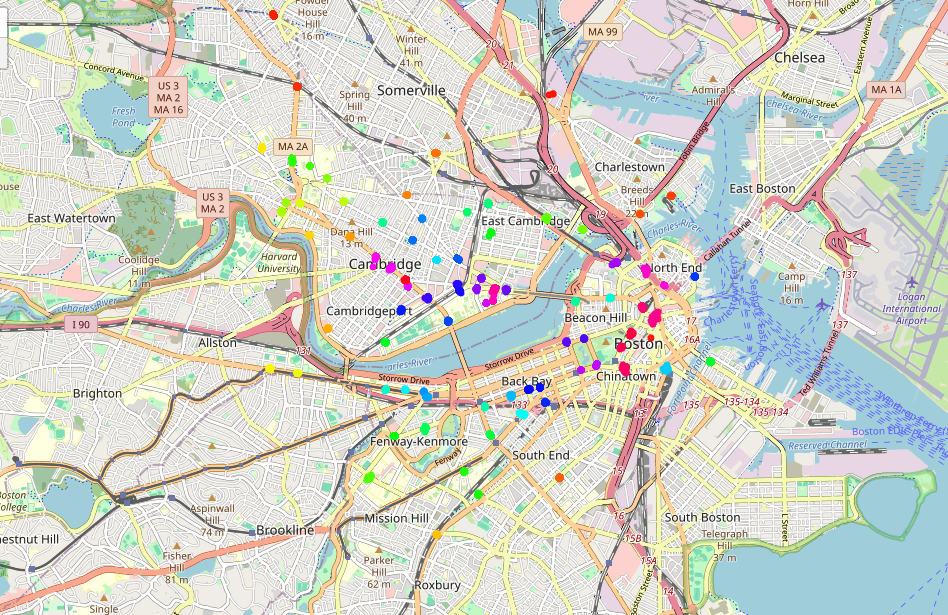

![Screenshot 2024-02-23 at 7.40.39 PM.png](<attachment:Screenshot 2024-02-23 at 7.40.39 PM.png>)
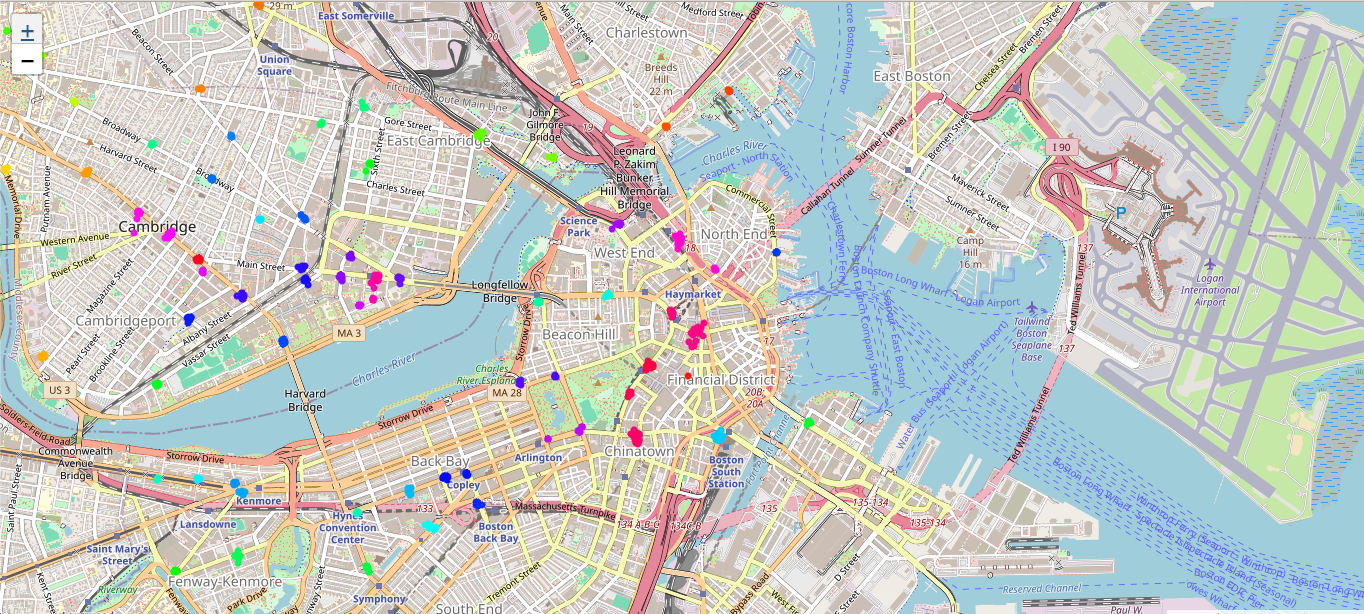

# **HDBSCAN ON DATA WITHOUT LAT N LONG AND `min_cluster_size` = 500**

In [150]:
non_geo_clustering_df = clustering_df_encoded.drop(['start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1)
non_geo_clustering_df

member_casual_casual  member_casual_member  \
0                          0                     1   
1                          0                     1   
2                          0                     1   
3                          0                     1   
4                          0                     1   
...                      ...                   ...   
631489                     0                     1   
631490                     0                     1   
631491                     0                     1   
631492                     0                     1   
631493                     0                     1   

        rideable_type_classic_bike  rideable_type_docked_bike  \
0                                0                          1   
1                                0                          1   
2                                0                          1   
3                                0                          1   
4                                0                          1   
...                            ...                        ...   
631489                           1                          0   
631490                           1                          0   
631491                           1                          0   
631492                           1                          0   
631493                           1                          0   

        rideable_type_electric_bike  start_station_district_Boston  \
0                                 0                              0   
1                                 0                              0   
2                                 0                              0   
3                                 0                              0   
4                                 0                              0   
...                             ...                            ...   
631489                            0                              1   
631490                            0                              1   
631491                            0                              1   
631492                            0                              1   
631493                            0                              1   

        start_station_district_Cambridge  start_station_district_Somerville  \
0                                      1                                  0   
1                                      1                                  0   
2                                      1                                  0   
3                                      1                                  0   
4                                      1                                  0   
...                                  ...                                ...   
631489                                 0                                  0   
631490                                 0                                  0   
631491                                 0                                  0   
631492                                 0                                  0   
631493                                 0                                  0   

        end_station_district_Arlington  end_station_district_Boston  \
0                                    0                            0   
1                                    0                            0   
2                                    0                            0   
3                                    0                            1   
4                                    0                            0   
...                                ...                          ...   
631489                               0                            1   
631490                               0                            1   
631491                               0                            1   
631492                               0                            0   
631493 

In [151]:
non_geo_clustering_df.drop(['start_station_district_Boston',
       'start_station_district_Cambridge', 'start_station_district_Somerville',
       'end_station_district_Arlington', 'end_station_district_Boston',
       'end_station_district_Brookline', 'end_station_district_Cambridge',
       'end_station_district_Chelsea', 'end_station_district_Everett',
       'end_station_district_Malden', 'end_station_district_Medford',
       'end_station_district_Newton', 'end_station_district_Revere',
       'end_station_district_Salem', 'end_station_district_Somerville',
       'end_station_district_Watertown'], inplace=True, axis=1)

In [69]:
# Initializing the model
non_geo_clusterer = hdbscan.HDBSCAN(min_cluster_size=500, 
                            min_samples=None,  # Default: same as min_cluster_size
                            gen_min_span_tree=True,
                            metric='euclidean',  
                            cluster_selection_epsilon=0.0,  # Adjust based on your needs
                            allow_single_cluster=False)  # Adjust based on your analysis goals

# Fitting the model
non_geo_clusterer.fit(non_geo_clustering_df)


non_geo_clustering_df['clusters'] = non_geo_clusterer.labels_

In [70]:
print('Total number of clusters:', non_geo_clustering_df['clusters'].max())

non_geo_clustering_df['clusters'].value_counts()


Total number of clusters: 9


clusters
 9    410703
-1    123867
 5     61817
 6     16219
 7      8003
 2      3752
 8      2582
 3      2180
 4      1486
 1       575
 0       310
Name: count, dtype: int64

In [71]:
non_geo_clustering_df

member_casual_casual  member_casual_member  \
0                          0                     1   
1                          0                     1   
2                          0                     1   
3                          0                     1   
4                          0                     1   
...                      ...                   ...   
631489                     0                     1   
631490                     0                     1   
631491                     0                     1   
631492                     0                     1   
631493                     0                     1   

        rideable_type_classic_bike  rideable_type_docked_bike  \
0                                0                          1   
1                                0                          1   
2                                0                          1   
3                                0                          1   
4                                0                          1   
...                            ...                        ...   
631489                           1                          0   
631490                           1                          0   
631491                           1                          0   
631492                           1                          0   
631493                           1                          0   

        rideable_type_electric_bike  duration_minutes  trip_distance  \
0                                 0         -0.019967       0.921413   
1                                 0         -0.013607       0.223011   
2                                 0         -0.045848      -1.050537   
3                                 0          0.004753       2.060342   
4                                 0         -0.043636      -0.499777   
...                             ...               ...            ...   
631489                            0         -0.037055       0.044217   
631490                            0         -0.047009      -0.495071   
631491                            0         -0.037276      -0.495071   
631492                            0         -0.000998       0.859560   
631493                            0         -0.038493      -0.945971   

        trip_frequency   AvgTemp  start_month  start_day  start_hour  \
0            -0.792772  0.641189    -1.436842   0.023919    0.535950   
1            -0.752695 -0.692104    -1.436842   0.023919    0.535950   
2            -0.792772  0.641189    -1.436842   0.023919    1.147033   
3            -0.752695 -0.877284    -1.436842   1.048291    0.739644   
4            -0.752695 -0.729140    -1.436842   1.048291   -0.482520   
...                ...       ...          ...        ...         ...   
631489       -0.680788 -1.877253     1.444805   0.536105   -1.500991   
631490        0.068011 -0.506925     1.444805   1.560476    1.350727   
631491        0.068011 -0.506925     1.444805   1.560476   -0.686214   
631492        0.068011 -1.284679     1.444805   1.048291    0.739644   
631493       -0.680788 -2.284648     1.444805   0.536105   -0.278826   

        start_station_danger_score_.5m  start_station_danger_score_1m  \
0                            -0.868047                      -1.262638   
1                            -0.868047                      -1.151002   
2                            -0.868047                      -1.262638   
3                            -0.868047                      -1.151002   
4                            -0.868047                      -1.151002   
...                                ...                            ...   
631489                        0.469550                       0.214393   
631490                        0.289705                      -0.026054   
631491                        0.289705                      -0.026054   
631492                        0.289705                      -0.026054   
631493                        0.469550       

In [80]:
clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631494 entries, 0 to 631493
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   start_lat                       631494 non-null  float64
 1   start_lng                       631494 non-null  float64
 2   end_lat                         631494 non-null  float64
 3   end_lng                         631494 non-null  float64
 4   duration_minutes                631494 non-null  float64
 5   trip_distance                   631494 non-null  float64
 6   trip_frequency                  631494 non-null  int64  
 7   AvgTemp                         631494 non-null  float64
 8   start_month                     631494 non-null  int32  
 9   start_day                       631494 non-null  int32  
 10  start_hour                      631494 non-null  int32  
 11  member_casual                   631494 non-null  object 
 12  rideable_type   

In [81]:
non_geo_clustering_df[['member_casual', 'rideable_type', 'start_station_district', 'end_station_district', 'start_lat', 'start_lng', 'end_lat', 'end_lng']] = clustering_df[['member_casual', 'rideable_type', 'start_station_district', 'end_station_district', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]

In [88]:
clustering_df

start_lat  start_lng    end_lat    end_lng  duration_minutes  \
0       42.365994 -71.095222  42.386748 -71.119019         14.583333   
1       42.370803 -71.104412  42.386748 -71.119019         16.500000   
2       42.365994 -71.095222  42.361358 -71.096703          6.783333   
3       42.370803 -71.104412  42.363871 -71.050877         22.033333   
4       42.370803 -71.104412  42.361358 -71.096703          7.450000   
...           ...        ...        ...        ...               ...   
631489  42.365673 -71.064263  42.349544 -71.072421          9.433333   
631490  42.351692 -71.119035  42.347241 -71.105301          6.433333   
631491  42.351692 -71.119035  42.347241 -71.105301          9.366667   
631492  42.351692 -71.119035  42.374267 -71.100265         20.300000   
631493  42.365673 -71.064263  42.369885 -71.069957          9.000000   

        trip_distance  trip_frequency  AvgTemp  start_month  start_day  \
0            1.877944            5445     68.5            4          3   
1            1.329318            5654     50.5            4          3   
2            0.328890            5445     68.5            4          3   
3            2.772623            5654     48.0            4          5   
4            0.761536            5654     50.0            4          5   
...               ...             ...      ...          ...        ...   
631489       1.188867            6029     34.5           12          4   
631490       0.765234            9934     53.0           12          6   
631491       0.765234            9934     53.0           12          6   
631492       1.829355            9934     42.5           12          5   
631493       0.411032            6029     29.0           12          4   

        start_hour member_casual rideable_type  \
0               17        member   docked_bike   
1               17        member   docked_bike   
2               20        member   docked_bike   
3               18        member   docked_bike   
4               12        member   docked_bike   
...            ...           ...           ...   
631489           7        member  classic_bike   
631490          21        member  classic_bike   
631491          11        member  classic_bike   
631492          18        member  classic_bike   
631493          13        member  classic_bike   

        start_station_danger_score_.5m  start_station_danger_score_1m  \
0                                  0.0                            5.0   
1                                  0.0                           31.0   
2                                  0.0                            5.0   
3                                  0.0                           31.0   
4                                  0.0                           31.0   
...                                ...                            ...   
631489                           119.0                          349.0   
631490                           103.0                          293.0   
631491                           103.0                          293.0   
631492                           103.0                          293.0   
631493                           119.0                          349.0   

        start_station_total_docks start_station_district  \
0                            19.0              Cambridge   
1                            23.0              Cambridge   
2                            19.0              Cambridge   
3                            23.0              Cambridge   
4                            23.0              Cambridge   
...                           ...                    ...   
631489                       36.0                 Boston   
631490                       15.0                 Boston   
631491                       15.0                 Boston   
631492                       15.0                 Boston   
631493                       36.0                 Boston   

        end_station_danger_score_.5m  end_station_dange

In [87]:
non_geo_clustering_df.drop(['member_casual_casual', 'member_casual_member',
       'rideable_type_classic_bike', 'rideable_type_docked_bike',
       'rideable_type_electric_bike'],inplace=True, axis=1)

In [95]:
non_geo_clustering_df.drop(['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal'], inplace=True, axis=1)

In [97]:
non_geo_clustering_df[['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal']] = clustering_df[['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal']]


In [99]:
non_geo_clustering_df.to_csv('/Users/parthmalik/Desktop/data/final_run_1.csv', index=False)

In [100]:
non_geo_clustering_df['clusters'].value_counts()

clusters
 9    410703
-1    123867
 5     61817
 6     16219
 7      8003
 2      3752
 8      2582
 3      2180
 4      1486
 1       575
 0       310
Name: count, dtype: int64

### New Run

In [152]:
non_geo_clustering_df = clustering_df_encoded.drop(['start_lat', 'start_lng'], axis=1)
non_geo_clustering_df
# 'start_lat', 'start_lng', 

member_casual_casual  member_casual_member  \
0                          0                     1   
1                          0                     1   
2                          0                     1   
3                          0                     1   
4                          0                     1   
...                      ...                   ...   
631489                     0                     1   
631490                     0                     1   
631491                     0                     1   
631492                     0                     1   
631493                     0                     1   

        rideable_type_classic_bike  rideable_type_docked_bike  \
0                                0                          1   
1                                0                          1   
2                                0                          1   
3                                0                          1   
4                                0                          1   
...                            ...                        ...   
631489                           1                          0   
631490                           1                          0   
631491                           1                          0   
631492                           1                          0   
631493                           1                          0   

        rideable_type_electric_bike  start_station_district_Boston  \
0                                 0                              0   
1                                 0                              0   
2                                 0                              0   
3                                 0                              0   
4                                 0                              0   
...                             ...                            ...   
631489                            0                              1   
631490                            0                              1   
631491                            0                              1   
631492                            0                              1   
631493                            0                              1   

        start_station_district_Cambridge  start_station_district_Somerville  \
0                                      1                                  0   
1                                      1                                  0   
2                                      1                                  0   
3                                      1                                  0   
4                                      1                                  0   
...                                  ...                                ...   
631489                                 0                                  0   
631490                                 0                                  0   
631491                                 0                                  0   
631492                                 0                                  0   
631493                                 0                                  0   

        end_station_district_Arlington  end_station_district_Boston  \
0                                    0                            0   
1                                    0                            0   
2                                    0                            0   
3                                    0                            1   
4                                    0                            0   
...                                ...                          ...   
631489                               0                            1   
631490                               0                            1   
631491                               0                            1   
631492                               0                            0   
631493 

In [153]:
non_geo_clustering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631494 entries, 0 to 631493
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   member_casual_casual               631494 non-null  int64  
 1   member_casual_member               631494 non-null  int64  
 2   rideable_type_classic_bike         631494 non-null  int64  
 3   rideable_type_docked_bike          631494 non-null  int64  
 4   rideable_type_electric_bike        631494 non-null  int64  
 5   start_station_district_Boston      631494 non-null  int64  
 6   start_station_district_Cambridge   631494 non-null  int64  
 7   start_station_district_Somerville  631494 non-null  int64  
 8   end_station_district_Arlington     631494 non-null  int64  
 9   end_station_district_Boston        631494 non-null  int64  
 10  end_station_district_Brookline     631494 non-null  int64  
 11  end_station_district_Cambridge     6314

In [154]:
non_geo_clustering_df.drop(['start_station_district_Boston',
       'start_station_district_Cambridge', 'start_station_district_Somerville',
       'end_station_district_Arlington', 'end_station_district_Boston',
       'end_station_district_Brookline', 'end_station_district_Cambridge',
       'end_station_district_Chelsea', 'end_station_district_Everett',
       'end_station_district_Malden', 'end_station_district_Medford',
       'end_station_district_Newton', 'end_station_district_Revere',
       'end_station_district_Salem', 'end_station_district_Somerville',
       'end_station_district_Watertown'], inplace=True, axis=1)

In [155]:
non_geo_clustering_df

member_casual_casual  member_casual_member  \
0                          0                     1   
1                          0                     1   
2                          0                     1   
3                          0                     1   
4                          0                     1   
...                      ...                   ...   
631489                     0                     1   
631490                     0                     1   
631491                     0                     1   
631492                     0                     1   
631493                     0                     1   

        rideable_type_classic_bike  rideable_type_docked_bike  \
0                                0                          1   
1                                0                          1   
2                                0                          1   
3                                0                          1   
4                                0                          1   
...                            ...                        ...   
631489                           1                          0   
631490                           1                          0   
631491                           1                          0   
631492                           1                          0   
631493                           1                          0   

        rideable_type_electric_bike    end_lat    end_lng  duration_minutes  \
0                                 0  42.386748 -71.119019         -0.019967   
1                                 0  42.386748 -71.119019         -0.013607   
2                                 0  42.361358 -71.096703         -0.045848   
3                                 0  42.363871 -71.050877          0.004753   
4                                 0  42.361358 -71.096703         -0.043636   
...                             ...        ...        ...               ...   
631489                            0  42.349544 -71.072421         -0.037055   
631490                            0  42.347241 -71.105301         -0.047009   
631491                            0  42.347241 -71.105301         -0.037276   
631492                            0  42.374267 -71.100265         -0.000998   
631493                            0  42.369885 -71.069957         -0.038493   

        trip_distance  trip_frequency   AvgTemp  start_month  start_day  \
0            0.921413       -0.792772  0.641189    -1.436842   0.023919   
1            0.223011       -0.752695 -0.692104    -1.436842   0.023919   
2           -1.050537       -0.792772  0.641189    -1.436842   0.023919   
3            2.060342       -0.752695 -0.877284    -1.436842   1.048291   
4           -0.499777       -0.752695 -0.729140    -1.436842   1.048291   
...               ...             ...       ...          ...        ...   
631489       0.044217       -0.680788 -1.877253     1.444805   0.536105   
631490      -0.495071        0.068011 -0.506925     1.444805   1.560476   
631491      -0.495071        0.068011 -0.506925     1.444805   1.560476   
631492       0.859560        0.068011 -1.284679     1.444805   1.048291   
631493      -0.945971       -0.680788 -2.284648     1.444805   0.536105   

        start_hour  start_station_danger_score_.5m  \
0         0.535950                       -0.868047   
1         0.535950                       -0.868047   
2         1.147033                       -0.868047   
3         0.739644                       -0.868047   
4        -0.482520                       -0.868047   
...            ...                             ...   
631489   -1.500991                        0.469550   
631490    1.350727                        0.289705   
631491   -0.686214                        0.289705   
631492    0.739644                        0.289705   
631493   -0.278826                        0.469550   

        start_station_danger_score_1m  start_station_total_docks  \
0          

In [156]:
# Initializing the model
non_geo_clusterer = hdbscan.HDBSCAN(min_cluster_size=250, 
                            min_samples=None,  # Default: same as min_cluster_size
                            gen_min_span_tree=True,
                            metric='euclidean',  
                            cluster_selection_epsilon=0.0,  # Adjust based on your needs
                            allow_single_cluster=False)  # Adjust based on your analysis goals

# Fitting the model
non_geo_clusterer.fit(non_geo_clustering_df)


non_geo_clustering_df['clusters'] = non_geo_clusterer.labels_

In [157]:
print('Total number of clusters:', non_geo_clustering_df['clusters'].max())

non_geo_clustering_df['clusters'].value_counts()


Total number of clusters: 9


clusters
 9    410625
-1    123957
 5     61797
 6     16215
 7      8016
 2      3752
 8      2581
 3      2180
 4      1486
 1       575
 0       310
Name: count, dtype: int64

In [143]:
non_geo_clustering_df

member_casual_casual  member_casual_member  \
0                          0                     1   
1                          0                     1   
2                          0                     1   
3                          0                     1   
4                          0                     1   
...                      ...                   ...   
631489                     0                     1   
631490                     0                     1   
631491                     0                     1   
631492                     0                     1   
631493                     0                     1   

        rideable_type_classic_bike  rideable_type_docked_bike  \
0                                0                          1   
1                                0                          1   
2                                0                          1   
3                                0                          1   
4                                0                          1   
...                            ...                        ...   
631489                           1                          0   
631490                           1                          0   
631491                           1                          0   
631492                           1                          0   
631493                           1                          0   

        rideable_type_electric_bike  start_station_district_Boston  \
0                                 0                              0   
1                                 0                              0   
2                                 0                              0   
3                                 0                              0   
4                                 0                              0   
...                             ...                            ...   
631489                            0                              1   
631490                            0                              1   
631491                            0                              1   
631492                            0                              1   
631493                            0                              1   

        start_station_district_Cambridge  start_station_district_Somerville  \
0                                      1                                  0   
1                                      1                                  0   
2                                      1                                  0   
3                                      1                                  0   
4                                      1                                  0   
...                                  ...                                ...   
631489                                 0                                  0   
631490                                 0                                  0   
631491                                 0                                  0   
631492                                 0                                  0   
631493                                 0                                  0   

        end_station_district_Arlington  end_station_district_Boston  \
0                                    0                            0   
1                                    0                            0   
2                                    0                            0   
3                                    0                            1   
4                                    0                            0   
...                                ...                          ...   
631489                               0                            1   
631490                               0                            1   
631491                               0                            1   
631492                               0                            0   
631493 

In [144]:
non_geo_clustering_df[['member_casual', 'rideable_type', 'start_station_district', 'end_station_district']] = clustering_df[['member_casual', 'rideable_type', 'start_station_district', 'end_station_district']]

In [145]:
non_geo_clustering_df.drop(['member_casual_casual', 'member_casual_member',
       'rideable_type_classic_bike', 'rideable_type_docked_bike',
       'rideable_type_electric_bike'],inplace=True, axis=1)

In [146]:
non_geo_clustering_df.drop(['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal'], inplace=True, axis=1)

In [147]:
non_geo_clustering_df[['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal']] = clustering_df[['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal']]


In [148]:
non_geo_clustering_df

start_station_district_Boston  start_station_district_Cambridge  \
0                                   0                                 1   
1                                   0                                 1   
2                                   0                                 1   
3                                   0                                 1   
4                                   0                                 1   
...                               ...                               ...   
631489                              1                                 0   
631490                              1                                 0   
631491                              1                                 0   
631492                              1                                 0   
631493                              1                                 0   

        start_station_district_Somerville  end_station_district_Arlington  \
0                                       0                               0   
1                                       0                               0   
2                                       0                               0   
3                                       0                               0   
4                                       0                               0   
...                                   ...                             ...   
631489                                  0                               0   
631490                                  0                               0   
631491                                  0                               0   
631492                                  0                               0   
631493                                  0                               0   

        end_station_district_Boston  end_station_district_Brookline  \
0                                 0                               0   
1                                 0                               0   
2                                 0                               0   
3                                 1                               0   
4                                 0                               0   
...                             ...                             ...   
631489                            1                               0   
631490                            1                               0   
631491                            1                               0   
631492                            0                               0   
631493                            0                               0   

        end_station_district_Cambridge  end_station_district_Chelsea  \
0                                    1                             0   
1                                    1                             0   
2                                    1                             0   
3                                    0                             0   
4                                    1                             0   
...                                ...                           ...   
631489                               0                             0   
631490                               0                             0   
631491                               0                             0   
631492                               1                             0   
631493                               1                             0   

        end_station_district_Everett  end_station_district_Malden  \
0                                  0                            0   
1                                  0                            0   
2                                  0                            0   
3                                  0                            0   
4                                  0                            0   
...                              ...              

In [149]:
non_geo_clustering_df.to_csv('/Users/parthmalik/Desktop/data/final_run_3.csv', index=False)

### **run 3, no lat n long no start n end stations district `min_cluster_size = 750`**

In [133]:
non_geo_clustering_df = clustering_df_encoded.drop(['start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1)
non_geo_clustering_df

member_casual_casual  member_casual_member  \
0                          0                     1   
1                          0                     1   
2                          0                     1   
3                          0                     1   
4                          0                     1   
...                      ...                   ...   
631489                     0                     1   
631490                     0                     1   
631491                     0                     1   
631492                     0                     1   
631493                     0                     1   

        rideable_type_classic_bike  rideable_type_docked_bike  \
0                                0                          1   
1                                0                          1   
2                                0                          1   
3                                0                          1   
4                                0                          1   
...                            ...                        ...   
631489                           1                          0   
631490                           1                          0   
631491                           1                          0   
631492                           1                          0   
631493                           1                          0   

        rideable_type_electric_bike  start_station_district_Boston  \
0                                 0                              0   
1                                 0                              0   
2                                 0                              0   
3                                 0                              0   
4                                 0                              0   
...                             ...                            ...   
631489                            0                              1   
631490                            0                              1   
631491                            0                              1   
631492                            0                              1   
631493                            0                              1   

        start_station_district_Cambridge  start_station_district_Somerville  \
0                                      1                                  0   
1                                      1                                  0   
2                                      1                                  0   
3                                      1                                  0   
4                                      1                                  0   
...                                  ...                                ...   
631489                                 0                                  0   
631490                                 0                                  0   
631491                                 0                                  0   
631492                                 0                                  0   
631493                                 0                                  0   

        end_station_district_Arlington  end_station_district_Boston  \
0                                    0                            0   
1                                    0                            0   
2                                    0                            0   
3                                    0                            1   
4                                    0                            0   
...                                ...                          ...   
631489                               0                            1   
631490                               0                            1   
631491                               0                            1   
631492                               0                            0   
631493 

In [134]:
non_geo_clustering_df.drop(['start_station_district_Boston',
       'start_station_district_Cambridge', 'start_station_district_Somerville',
       'end_station_district_Arlington', 'end_station_district_Boston',
       'end_station_district_Brookline', 'end_station_district_Cambridge',
       'end_station_district_Chelsea', 'end_station_district_Everett',
       'end_station_district_Malden', 'end_station_district_Medford',
       'end_station_district_Newton', 'end_station_district_Revere',
       'end_station_district_Salem', 'end_station_district_Somerville',
       'end_station_district_Watertown'], inplace=True, axis=1)

In [135]:
non_geo_clustering_df

member_casual_casual  member_casual_member  \
0                          0                     1   
1                          0                     1   
2                          0                     1   
3                          0                     1   
4                          0                     1   
...                      ...                   ...   
631489                     0                     1   
631490                     0                     1   
631491                     0                     1   
631492                     0                     1   
631493                     0                     1   

        rideable_type_classic_bike  rideable_type_docked_bike  \
0                                0                          1   
1                                0                          1   
2                                0                          1   
3                                0                          1   
4                                0                          1   
...                            ...                        ...   
631489                           1                          0   
631490                           1                          0   
631491                           1                          0   
631492                           1                          0   
631493                           1                          0   

        rideable_type_electric_bike  duration_minutes  trip_distance  \
0                                 0         -0.019967       0.921413   
1                                 0         -0.013607       0.223011   
2                                 0         -0.045848      -1.050537   
3                                 0          0.004753       2.060342   
4                                 0         -0.043636      -0.499777   
...                             ...               ...            ...   
631489                            0         -0.037055       0.044217   
631490                            0         -0.047009      -0.495071   
631491                            0         -0.037276      -0.495071   
631492                            0         -0.000998       0.859560   
631493                            0         -0.038493      -0.945971   

        trip_frequency   AvgTemp  start_month  start_day  start_hour  \
0            -0.792772  0.641189    -1.436842   0.023919    0.535950   
1            -0.752695 -0.692104    -1.436842   0.023919    0.535950   
2            -0.792772  0.641189    -1.436842   0.023919    1.147033   
3            -0.752695 -0.877284    -1.436842   1.048291    0.739644   
4            -0.752695 -0.729140    -1.436842   1.048291   -0.482520   
...                ...       ...          ...        ...         ...   
631489       -0.680788 -1.877253     1.444805   0.536105   -1.500991   
631490        0.068011 -0.506925     1.444805   1.560476    1.350727   
631491        0.068011 -0.506925     1.444805   1.560476   -0.686214   
631492        0.068011 -1.284679     1.444805   1.048291    0.739644   
631493       -0.680788 -2.284648     1.444805   0.536105   -0.278826   

        start_station_danger_score_.5m  start_station_danger_score_1m  \
0                            -0.868047                      -1.262638   
1                            -0.868047                      -1.151002   
2                            -0.868047                      -1.262638   
3                            -0.868047                      -1.151002   
4                            -0.868047                      -1.151002   
...                                ...                            ...   
631489                        0.469550                       0.214393   
631490                        0.289705                      -0.026054   
631491                        0.289705                      -0.026054   
631492                        0.289705                      -0.026054   
631493                        0.469550       

In [136]:
# Initializing the model
non_geo_clusterer = hdbscan.HDBSCAN(min_cluster_size=810, 
                            min_samples=None,  # Default: same as min_cluster_size
                            gen_min_span_tree=True,
                            metric='euclidean',  
                            cluster_selection_epsilon=0.0,  # Adjust based on your needs
                            allow_single_cluster=False)  # Adjust based on your analysis goals

# Fitting the model
non_geo_clusterer.fit(non_geo_clustering_df)


non_geo_clustering_df['clusters'] = non_geo_clusterer.labels_

In [137]:
print('Total number of clusters:', non_geo_clustering_df['clusters'].max())

non_geo_clustering_df['clusters'].value_counts()

Total number of clusters: 1


clusters
 1    551054
-1     77658
 0      2782
Name: count, dtype: int64

In [ ]:
non_geo_clustering_df[['member_casual', 'rideable_type', 'start_station_district', 'end_station_district', 'start_lat', 'start_lng', 'end_lat', 'end_lng']] = clustering_df[['member_casual', 'rideable_type', 'start_station_district', 'end_station_district', 'start_lat', 'start_lng', 'end_lat', 'end_lng']]

In [ ]:
non_geo_clustering_df.drop(['member_casual_casual', 'member_casual_member',
       'rideable_type_classic_bike', 'rideable_type_docked_bike',
       'rideable_type_electric_bike'],inplace=True, axis=1)

In [ ]:
non_geo_clustering_df.drop(['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal'], inplace=True, axis=1)

In [ ]:
non_geo_clustering_df[['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal']] = clustering_df[['duration_minutes', 'trip_distance', 'trip_frequency', 'AvgTemp',
       'start_month', 'start_day', 'start_hour',
       'start_station_danger_score_.5m', 'start_station_danger_score_1m',
       'start_station_total_docks', 'end_station_danger_score_.5m',
       'end_station_danger_score_1m', 'end_station_total_docks',
       'season_ordinal']]
